In [1]:
import tensorflow as tf
import numpy as np
from random import randint
import matplotlib.pyplot as plt

import tensorflow_nn

%matplotlib inline

In [2]:
tf.reset_default_graph()

In [3]:
num_neurons = 125
iterations = 1000

### Defining connections

In [4]:
num_of_e_neurons = 100
num_of_i_neurons = 25

connections = []
connection_weights = []
for i in range(num_neurons):
    temp_conns = []
    temp_weights = []
    
    if i < num_of_e_neurons:
        count = 0
        for j in range(num_of_e_neurons):
            if i != j:
                number = randint(0, 99)
                if number < 10:
                    temp_conns.append(j)
                    count = count + 1
        temp_weights.extend(np.random.normal(.1, .05, count).tolist())
        
        count = 0
        for j in range(num_of_e_neurons, num_of_e_neurons + num_of_i_neurons):
            if i != j:
                number = randint(0, 99)
                if number < 10:
                    temp_conns.append(j)
                    count = count + 1
        temp_weights.extend(np.random.normal(.1, .05, count).tolist())
    else:
        count = 0
        for j in range(num_of_e_neurons):
            if i != j:
                number = randint(0, 99)
                if number < 15:
                    temp_conns.append(j)
                    count = count + 1
        temp_weights.extend(np.random.normal(.1, .05, count).tolist())

                
    connections.append(tf.Variable(np.asarray(temp_conns), dtype=tf.int32))
    connection_weights.append(tf.Variable(np.asarray(temp_weights), dtype=tf.float32))

### Defining initial state

In [5]:
inputs = tf.Variable(np.array([[0.]*(num_neurons)] * iterations))

v_initial = tf.Variable(np.array([-40.]*num_neurons), dtype=tf.float32)
n_initial = tf.Variable(np.array([-40.]*num_neurons), dtype=tf.float32)
h_initial = tf.Variable(np.array([-40.]*num_neurons), dtype=tf.float32)

fired_initial = tf.zeros(num_neurons)
fired_iteration = tf.zeros(num_neurons)

initial_state = tensorflow_nn.BNNState(
    rk_variables=[v_initial, n_initial, h_initial], iteration=tf.Variable(0.), fired=fired_initial,
        fired_iteration=fired_iteration
)

### Defining custom current functions

In [6]:
ve = tf.Variable(np.random.normal(-65., 2, num_neurons), dtype=tf.float32)
gl = tf.Variable(np.random.normal(0.002, 0.0001, num_neurons), dtype=tf.float32)
dc = tf.Variable(np.random.normal(0.1, 0.1, num_neurons), dtype=tf.float32)

def fIl(rk_variables, iteration, fired, fired_iteration, step_input, connections, connection_weights):
    #rk variables
    v, n, h = rk_variables
        
    v_new = tf.add(tf.multiply(gl, tf.subtract(ve, v)), dc)
        
    return [v_new, None, None]

tau = tf.constant(100.)
vs_ampa = tf.constant(0.) 
vs_gaba = tf.constant(-90.) 
def fIs(rk_variables, iteration, fired, fired_iteration, step_input, connections, connection_weights):        
    #rk variables
    v, n, h = rk_variables
    
    mul_product = []

    for i in range(num_neurons):
        #ampa synapses
        ampa_indices = tf.where(connections[i] < num_of_e_neurons)
        ampa_gather = tf.gather(tf.multiply(v, fired), tf.gather(connections[i], ampa_indices))
        ampa_weighted_gather = tf.multiply(tf.subtract(vs_ampa, ampa_gather),
                                           tf.gather(connection_weights[i], ampa_indices))

        #gaba synapses
        gaba_indices = tf.where(connections[i] >= num_of_e_neurons)
        gaba_gather = tf.gather(tf.multiply(v, fired), tf.gather(connections[i], gaba_indices))
        gaba_weighted_gather = tf.multiply(tf.subtract(vs_gaba, gaba_gather),
                                           tf.gather(connection_weights[i], gaba_indices))

        weighted_gather = tf.concat([ampa_weighted_gather, gaba_weighted_gather], 0)
        
        wg_mul_by_gs = tf.multiply(tf.exp(tf.divide(tf.subtract(iteration, fired_iteration), tau)), weighted_gather)
        
        mul_product.append(tf.reduce_sum(wg_mul_by_gs)) 

    return [tf.stack(mul_product, 0), None, None]
    
current_functions = [fIl, fIs]

### Instantiate and run the simulation

In [7]:
bnn = tensorflow_nn.TFBNN(
    num_neurons=num_neurons, iterations=iterations, h=tf.constant(0.01), firing_threshold=tf.constant(-50.),
    firing_reset=tf.constant(-65.), current_functions=current_functions, initial_state=initial_state,
    inputs=inputs, connections=connections, connection_weights=connection_weights
)

In [8]:
%%time
output = bnn.run_simulation()

CPU times: user 2min 31s, sys: 1min 26s, total: 3min 57s
Wall time: 1min 40s


//anaconda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


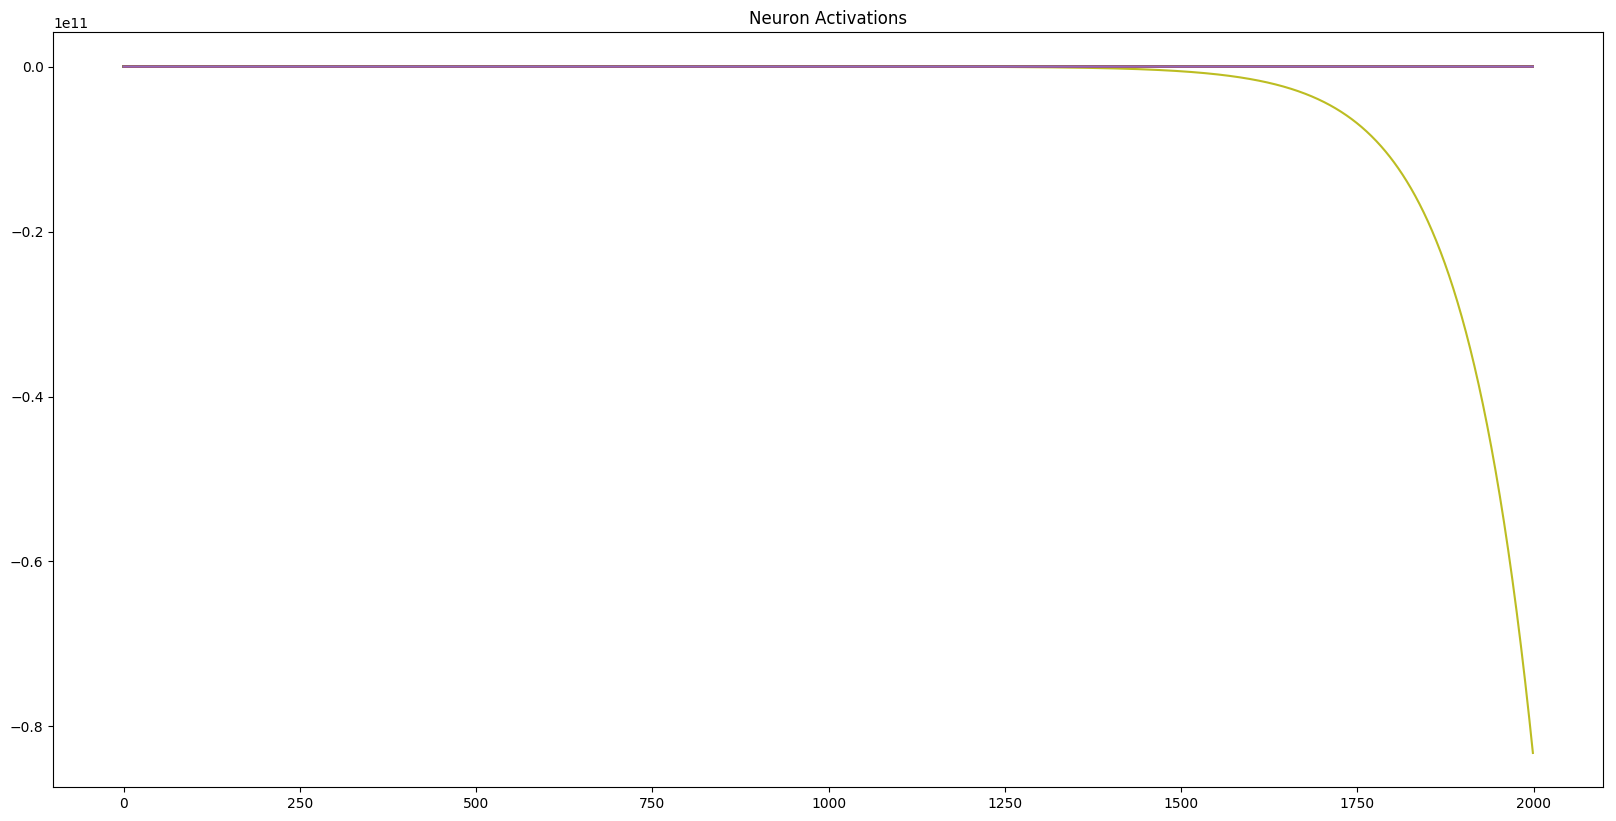

In [10]:
plt.figure(figsize=(20,10))
plt.title('Neuron Activations')
n = 125
for i in range(n):
    plt.plot([y[i] for y in output[0][0]])#, label='v_'+str(i), alpha=(i+1.0)/(n))
plt.legend()
plt.show()